## This whole notebook is based off of the steps seen **[here](https://anomaly.io/seasonal-trend-decomposition-in-r/index.html)**. For the purpose of simplicity this is just a replication of the logic for ONLY the `"multiplicative"` behavior of R's `decompose` as opposed to the `"additive"` behavior.

For this example, we use the `airpassengers` dataset. Its seasonal variation seems increasing so we use the `multiplicative` decomposition behavior. If its seasonal variation were to stay constant with time we would look into using the `additive` decomposition behavior.

## Setup

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from pmdarima.datasets import load_airpassengers

In [2]:
timeserie_airpassengers = load_airpassengers()

## Step 1: Import the Data 

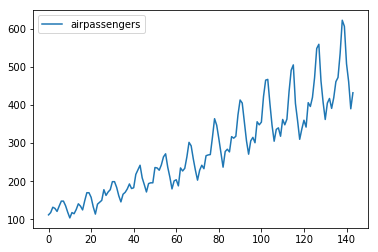

In [3]:
plt.plot(timeserie_airpassengers, label="airpassengers")
plt.legend()
plt.show()

## Step 2: Detect the Trend

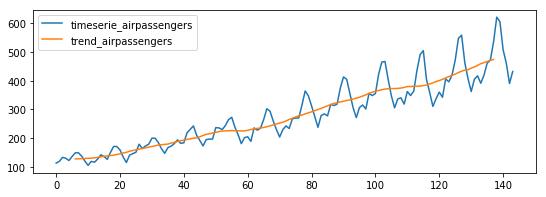

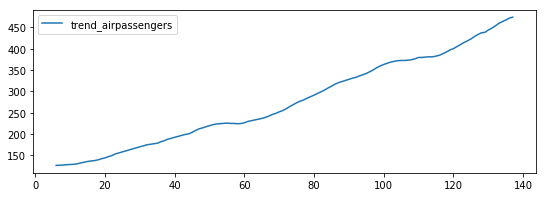

In [4]:
# We mimic the centered SMA behavior over the quarterly data.
N = 12 # monthly
half_N = int(N/2.)
trend_airpassengers = np.convolve(timeserie_airpassengers, np.ones((N,))/N, mode='valid')
trend_airpassengers = trend_airpassengers[:-1] # we remove the final index.
# The simple moving average is centered because it shifts from the 0th index to the N/2 index
moving_average_x = range(half_N, len(trend_airpassengers) + half_N)
# Plot the original signal with the trend
plt.figure(figsize=(9,3))
plt.plot(timeserie_airpassengers, label="timeserie_airpassengers")
plt.plot(moving_average_x, trend_airpassengers, label="trend_airpassengers")
plt.legend()
plt.show()
plt.figure(figsize=(9,3))
plt.plot(moving_average_x, trend_airpassengers, label="trend_airpassengers")
plt.legend()
plt.show()

## Step 3: Detrend the Time Series

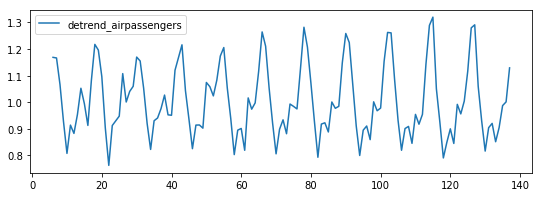

In [5]:
# Remove the effects of the trend and then plot.
detrend_airpassengers = timeserie_airpassengers[moving_average_x] / trend_airpassengers
plt.figure(figsize=(9,3))
plt.plot(moving_average_x, detrend_airpassengers, label="detrend_airpassengers")
plt.legend()
plt.show()

## Step 4: Average the Seasonality

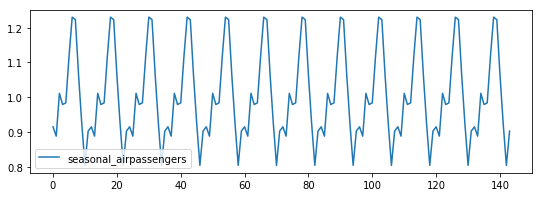

In [6]:

# Reshape the array to 15 by 12 so that it reflects the quarters over the 60 points
# from the range of points that overlap the SMA.
m_airpassengers = np.reshape(detrend_airpassengers, (int(detrend_airpassengers.shape[0] / N), N))

# We take the mean with respect to the columns and then shift the columns
# This is due to the math of the centered SMA that we have to do the offset of N/2.
seasonal_airpassengers = np.nanmean(m_airpassengers, axis=0).tolist()
seasonal_airpassengers = np.array(seasonal_airpassengers[half_N:] + seasonal_airpassengers[:half_N])
temp = seasonal_airpassengers

# Build 12 cycles before plotting since we start with 1 we concatenate 11 times
for i in range(11):
    seasonal_airpassengers = np.concatenate((seasonal_airpassengers, temp))

# Plot the seasonal airpassengers count. This should be a repetitive pattern with period 12, and cycles=12
plt.figure(figsize=(9,3))
plt.plot(seasonal_airpassengers, label="seasonal_airpassengers")
plt.legend()
plt.show()

## Step 5: Examining Remaining Random Noise

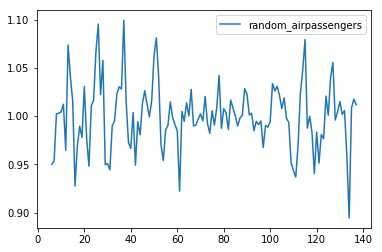

In [7]:
# Add NaN to beginning and end of time series to make the dimensions match for array subtraction.
# This buffer is created relative to half the size of N.
buffer = []
for i in range(half_N):
    buffer.append(np.nan)
trend_airpassengers_buffered = np.array(buffer + trend_airpassengers.tolist() + buffer)

# Subtract the effects of the trend and the seasonality to get the remaining noise/randomness of the time series
random_airpassengers = timeserie_airpassengers / (trend_airpassengers_buffered * seasonal_airpassengers)
plt.plot(random_airpassengers, label="random_airpassengers")
plt.legend()
plt.show()

## Step 6: Reconstruct the Original Signal

### Recomposed Signal
- **FYI: It is okay that there are missing points because the SMA has leading and lagging points removed**

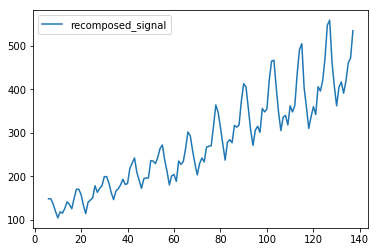

In [8]:
recomposed_signal = trend_airpassengers_buffered * seasonal_airpassengers * random_airpassengers
plt.plot(recomposed_signal, label="recomposed_signal")
plt.legend()
plt.show()

### Original Signal

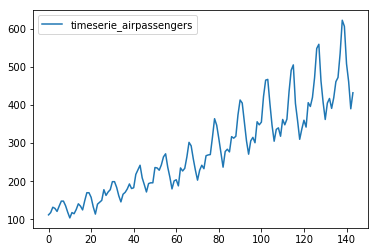

In [9]:
plt.plot(timeserie_airpassengers, label="timeserie_airpassengers")
plt.legend()
plt.show()

## Assert `decompose` matches generated output which matches R's implementation of `decompose` 

In [10]:
from pmdarima.arima.seasonality import decompose
from numpy.testing import assert_array_equal, assert_array_almost_equal
decomposed = decompose(timeserie_airpassengers, 'multiplicative', f=12)

assert_array_equal(decomposed.x, timeserie_airpassengers)
assert_array_equal(decomposed.trend, trend_airpassengers_buffered)
assert_array_equal(decomposed.seasonal, seasonal_airpassengers)
assert_array_almost_equal(decomposed.random, random_airpassengers, decimal=10)

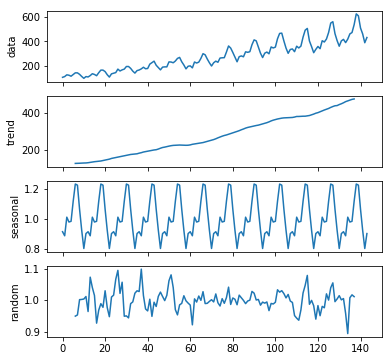

In [13]:
from pmdarima.utils.visualization import decomposed_plot

figure_kwargs = {'figsize': (6, 6)}
axes = decomposed_plot(decomposed, figure_kwargs=figure_kwargs, show=False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()